## Implementation of Kmeans and Kmeans++ Algorithm from Scratch Evaluating Performance with Iris Data Set. Comparing results with Sklearn package on Countries dataset.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rnd
import sys
import matplotlib as mpl

from sklearn.decomposition import PCA
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

#### Step1: Implementing the function

In [3]:
class KmeansClustering_manual():
    
    """
    > class initialization with number of clusters, centroid initialization, random state and max iteration value
    > max iternation will determine the maximum number of times loop will run to detrmine centroid when centroid
    values are not converging.
    > initialization parameter determines which type of centroid initialization we want. kmeans/kmeans++
    > random_state parameter determines the reproducible output everytime algorithm runs
    """
    def __init__(self, n_cluster=3, initialization='kmeans', random_state=265, max_interations = 300):
        self.ncluster=n_cluster
        self.initial = initialization
        self.itercount = max_interations
        rnd.seed(random_state)
    
    #initializing centroids randomly as per basic k-means rule
    def randomizeinput_initalcentroids(self, X):
        shape_X = X.shape[0]
        
        #converting input data to array for consistent calculations
        if (type(X) != np.ndarray): 
            self.to_array_X = np.array(X)
        else:
            self.to_array_X = X
        
        len_X = len(self.to_array_X)
        
        if(shape_X < self.ncluster):
            raise ValueError ("The number of cluster should be greater or equal to number of rows in dataset")
                   
        #the loop will randomly take n rows from the dataset and assign it as centroids
        #each row is a cluster and each column is a centroid of each feature
        centroids = list() 
        for i in range(0,self.ncluster):
            sample_idx = rnd.randrange(0,len_X,1)
            sampled_row_X = self.to_array_X[sample_idx]
            centroids.append(sampled_row_X)
        return centroids
    
    #initializing centroids as per k-means++ rule
    """
        Step1:  randomly a row is selected from the dataset as the first cluster. the row is a cluster
                the columns is a centorid of each feature.
        Step2A: rest of the clusters are determined by running a loop for each cluster
        Step2B: distance of each data points for each feature is calculated from its respective feature-centroid
                this feature centroid is calculated in Step1. As there can be more than one cluster, 
                thus for each cluster, distance of every datapoint is measured from respective centroid 
                in #Step2B_cntd. the points which nearer to a previously determined centroids are logged in
                distance_mat list. 
        Step3:  from this list, the point having maximum distance is then chosen to be the next centroid. 
                these steps are repeated n times where n is the number of clusters.
                this ensures that the three centroids are as far away as possible fro each other.   
    """
    def kmeans_pp_initialization(self, X):
        shape_X = X.shape[0]
        
        #converting input data to array for consistent calculations
        if (type(X) != np.ndarray):
            self.to_array_X = np.array(X)
        else:
            self.to_array_X = X
            
        len_X = len(self.to_array_X)
        
        if(shape_X < self.ncluster):
            raise ValueError ("The number of cluster should be greater or equal to number of rows in dataset")
        
        #Step1
        centroids = list()
        sample_idx = rnd.randrange(0,len_X,1)
        sampled_row_X = self.to_array_X[sample_idx]
        centroids.append(sampled_row_X)
        
        #Step2A
        for i in range(self.ncluster - 1):
            distance_mat = []
            
            #Step2B
            for point in range(len(self.to_array_X)):
                distance = sys.maxsize
                
                #Step2B_cntd
                for j in range(len(centroids)):
                    distance_from_each_centroid = np.sqrt(((self.to_array_X[point]-centroids[j])**2).sum())
                    distance = min(distance, distance_from_each_centroid)
                
                distance_mat.append(distance)
            
            #Step3
            #distance_mat = np.array(distance_mat)
            next_centroid = self.to_array_X[np.argmax(distance_mat)]
            centroids.append(next_centroid)
                
        return centroids
        
    #distance matrix calculation for each data point while updating cluster centroids
    def calculate_distance(self, centroids):
        distance_mat = list()
        for i in range(len(self.to_array_X)):
            distance_mat.append(list(np.sqrt(((self.to_array_X[i]-centroids)**2).sum(axis=1))))
        return distance_mat
    
    #finding out the labels of each datapoint that indicates which cluster a datapoint (row) belongs to
    def get_labels(self, distance_mat):
        labellist = np.argmin(distance_mat, axis=1)
        return labellist

    #this calculates the new centroid after taking the geometric mean of each feature of all the datapoints  
    #belonging to a particular cluster. This step is called while updating centroids of each cluster
    def calculate_new_centroids(self, labels):
        centroids_updated = list()
        uniqeuelables = np.unique(labels)
        for i in sorted(uniqeuelables):
            data_label_i = self.to_array_X[np.where(labels==i)]
            new_centroid = np.mean(data_label_i,axis=0) #np.exp(np.log(data_label_i).mean(axis=0))
            centroids_updated.append(new_centroid)
        return centroids_updated
    
    #additional function to visualize how the centroids are being updated for each cluster
    #PCA is called to reduce the diemension to two variables thus easirer to visualize
    def plot_clusters(self, labels, centroids, iters):
        pca = PCA(n_components=2, random_state=265)
        data2d = pca.fit_transform(self.to_array_X)
        centroids2d = pca.transform(centroids)
        clear_output(wait=True)
        plt.title(f'Iteration:{iters}')
        plt.scatter(x=data2d[:,0],y=data2d[:,1],c=labels)
        plt.scatter(x=centroids2d[:,0],y=centroids2d[:,1], c='r')
        plt.show()
    
    #the final function which is equivalent to the 'fit' function. This function runs the loop to
    #update centroids for each cluster.
    def update_centroids(self, X):
        
        centroids=[]
        if(self.initial=='kmeans++'):
            centroids = self.kmeans_pp_initialization(X)
        else:
            centroids = self.randomizeinput_initalcentroids(X)
        
        iter_count = 1
        self.upd_centroid = list()
        self.final_labels = list()

        while iter_count<=self.itercount and not np.array_equal(self.upd_centroid,centroids):
            self.upd_centroid = centroids
            distance_mat = self.calculate_distance(self.upd_centroid)
            self.final_labels = self.get_labels(distance_mat)
            centroids = self.calculate_new_centroids(self.final_labels)
            
            self.plot_clusters(self.final_labels,self.upd_centroid,iter_count)
            iter_count+=1

#### Step2: Importing Iris dataset to test the manually written k-means algorithm

In [4]:
from sklearn.datasets import load_iris
data = load_iris()
iris_df = pd.DataFrame(data.data, columns = data.feature_names)
xt=np.array(iris_df)

In [13]:
kmmodel = KmeansClustering_manual(n_cluster=4, initialization='kmeans')

dis = kmmodel.calculate_distance(kmmodel.randomizeinput_initalcentroids(xt))

#dis
#np.argmin(dis,axis=1)

The below plot with Kmeans shows the disadvantage in the initial cluster determination which takes place randomly for the basic k-means algorithm. This can cause inefficient cluster determination. Cluster centroids are red in color.

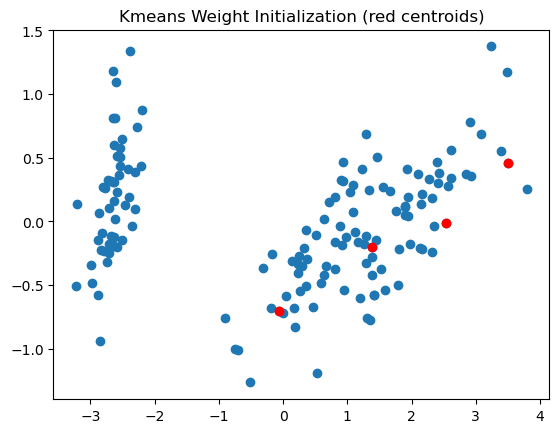

In [6]:
kmmodel = KmeansClustering_manual(n_cluster=4, initialization='kmeans')

initial_centroids=kmmodel.randomizeinput_initalcentroids(xt)
pca = PCA(n_components=2)
data2d = pca.fit_transform(xt)
centroids2d = pca.transform(initial_centroids)
clear_output(wait=True)
plt.title(f'Kmeans Weight Initialization (red centroids)')
plt.scatter(x=data2d[:,0],y=data2d[:,1])
plt.scatter(x=centroids2d[:,0],y=centroids2d[:,1], c='r')
plt.show()

The below plot indicates, how the initialization is modified with kmeans++ algorithm. This ensures that each initial centroid is as far away as possible from each other. Cluster centroids are red in color.

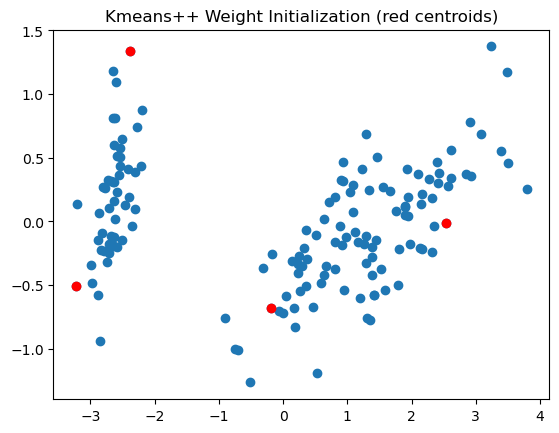

In [8]:
kmmodel = KmeansClustering_manual(n_cluster=4, initialization='kmeans++')

initial_centroids=kmmodel.kmeans_pp_initialization(xt)
pca = PCA(n_components=2)
data2d = pca.fit_transform(xt)
centroids2d = pca.transform(initial_centroids)
clear_output(wait=True)


plt.title(f'Kmeans++ Weight Initialization (red centroids)')
plt.scatter(x=data2d[:,0],y=data2d[:,1])
plt.scatter(x=centroids2d[:,0],y=centroids2d[:,1], c='r')

plt.show()

The following plot shows the final clusters of IRIS dataset (PCA 2 components) determined by kmeans++ algorithm.
The plot is dynamic and can help us visualize how the clusters are getting updated on each iteration. Cluster centroids are red in color.

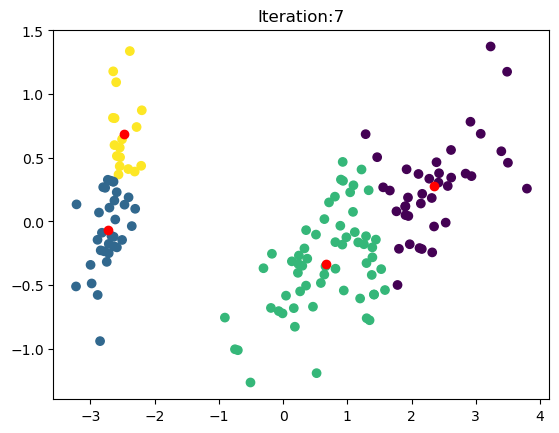

In [32]:
kmmodel = KmeansClustering_manual(n_cluster=4, initialization='kmeans++')
kmmodel.update_centroids(xt)

#### Step3: Using an external datasource (i.e. country information containing demogrpahic details of different countires) comparing the clustering result of sklearn kmeans library with algorithm manually written above

In [14]:
#Importing scaling package
from sklearn.preprocessing import MinMaxScaler

In [15]:
#Applyying 0-1 normalization (without country column) 
#and saving normalized dataset to a new excel along with country column.

country_info = pd.read_excel('country_information.xlsx')

mnscaler = MinMaxScaler()
country_info_scaled_temp = mnscaler.fit_transform(country_info.iloc[:,1:])

country_info_scaled_df = pd.DataFrame(country_info_scaled_temp, columns = country_info.columns[1:])
country_info_scaled_df['country'] = country_info['country']

country_info_scaled_df.to_excel("country_information_normalized.xlsx",engine='xlsxwriter', index=False)

country_info_scaled_df.head()

,gini_index,corruption_perceptions_index,freedom_house_democracy_index,hdi,press_freedom_index,economist_democracy_index,populism_index,effective_coverage_of_health_services_index,trust_in_news_media_index,trust_in_government_index,trust_in_science_index,country
0,0.415418,0.092105,0.0,0.000000,0.25,0.000000,0.441839,0.109375,0.501952,0.743412,0.153846,Afghanistan
1,0.239518,0.315789,0.5,0.666667,0.50,0.333333,0.562931,0.593750,0.306081,0.519163,0.153846,Albania
2,0.096609,0.315789,0.0,0.666667,0.25,0.333333,0.550136,0.515625,0.257206,0.738070,0.057692,Algeria
3,0.487058,0.394737,1.0,1.000000,0.50,0.666667,1.000000,0.453125,0.459459,0.153846,0.365385,Argentina
4,0.270142,0.855263,1.0,1.000000,0.75,1.000000,0.683351,0.890625,0.594595,0.323077,0.596154,Australia


**Summary of what the dataset is about.**
The dataset essentially provides us details about various indicators and indices related to social, political, and economic factors in different countries.
'country': the name of the country <br>
'gini_index': a measure of income inequality <br>
'corruption_perceptions_index': a measure of perceived corruption in the public sector <br>
'freedom_house_democracy_index': a measure of political freedom and civil liberties <br>
'hdi': the human development index, a composite measure of health, education, and standard of living <br>
'press_freedom_index': a measure of freedom of the press <br>
'economist_democracy_index': a measure of the quality of democracy and political participation <br>
'populism_index': a measure of the prevalence of populist attitudes and rhetoric <br>
'effective_coverage_of_health_services_index': a measure of the availability and quality of health services <br>
'trust_in_news_media_index': a measure of public trust in the news media <br>
'trust_in_government_index': a measure of public trust in the government <br>
'trust_in_science_index': a measure of public trust in science and scientific institutions <br>

In [16]:
#Pulling country_information_normalized excel for Kmeans++ analysis
country_info_normalized = pd.read_excel('country_information_normalized.xlsx')
country_info_normalized.head()

,gini_index,corruption_perceptions_index,freedom_house_democracy_index,hdi,press_freedom_index,economist_democracy_index,populism_index,effective_coverage_of_health_services_index,trust_in_news_media_index,trust_in_government_index,trust_in_science_index,country
0,0.415418,0.092105,0.0,0.000000,0.25,0.000000,0.441839,0.109375,0.501952,0.743412,0.153846,Afghanistan
1,0.239518,0.315789,0.5,0.666667,0.50,0.333333,0.562931,0.593750,0.306081,0.519163,0.153846,Albania
2,0.096609,0.315789,0.0,0.666667,0.25,0.333333,0.550136,0.515625,0.257206,0.738070,0.057692,Algeria
3,0.487058,0.394737,1.0,1.000000,0.50,0.666667,1.000000,0.453125,0.459459,0.153846,0.365385,Argentina
4,0.270142,0.855263,1.0,1.000000,0.75,1.000000,0.683351,0.890625,0.594595,0.323077,0.596154,Australia


In [17]:
#Taking only numeric columns
country_info_normalized_km = country_info_normalized.loc[:,['gini_index', 'corruption_perceptions_index',
       'freedom_house_democracy_index', 'hdi', 'press_freedom_index',
       'economist_democracy_index', 'populism_index',
       'effective_coverage_of_health_services_index',
       'trust_in_news_media_index', 'trust_in_government_index',
       'trust_in_science_index']]
                                                          
country_info_normalized_km.shape

(128, 11)

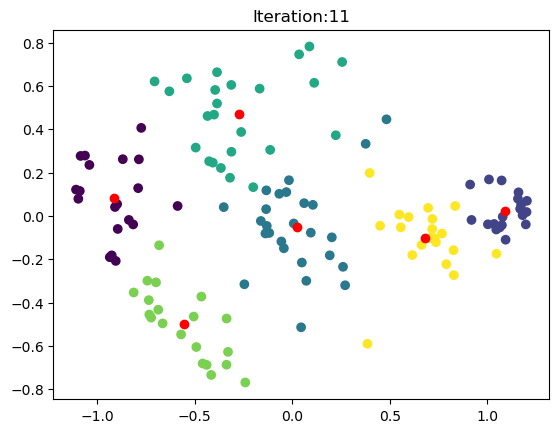

In [19]:
#Running Kmeans++ with k=6 (decided based on known information)
#the below graphs also output a PCA results
#keeping random state = 6 over here because that is when getting the best clustering result as per sklearn package

n_cluster=6
kmmodel_country = KmeansClustering_manual(n_cluster=n_cluster, initialization='kmeans++', random_state=6)
kmmodel_country.update_centroids(country_info_normalized_km)

In [20]:
#Updating labels to original dataframe:
labs = kmmodel_country.final_labels
cents = kmmodel_country.upd_centroid

country_info_normalized["kmeans_label"] = labs

In [115]:
country_info_normalized_km.head()

,gini_index,corruption_perceptions_index,freedom_house_democracy_index,hdi,press_freedom_index,economist_democracy_index,populism_index,effective_coverage_of_health_services_index,trust_in_news_media_index,trust_in_government_index,trust_in_science_index
0,0.415418,0.092105,0.0,0.000000,0.25,0.000000,0.441839,0.109375,0.501952,0.743412,0.153846
1,0.239518,0.315789,0.5,0.666667,0.50,0.333333,0.562931,0.593750,0.306081,0.519163,0.153846
2,0.096609,0.315789,0.0,0.666667,0.25,0.333333,0.550136,0.515625,0.257206,0.738070,0.057692
3,0.487058,0.394737,1.0,1.000000,0.50,0.666667,1.000000,0.453125,0.459459,0.153846,0.365385
4,0.270142,0.855263,1.0,1.000000,0.75,1.000000,0.683351,0.890625,0.594595,0.323077,0.596154


The below code compares the output of manually written Kmeans++ code with Sklearn Packaged Kmeans++ algorithm.
The results look pretty similar as per the graph.

In [21]:
from sklearn.cluster import KMeans

In [28]:
kmmodel_country_original = KMeans(n_clusters=6, init='k-means++', random_state=3)
orig_lab = kmmodel_country_original.fit_predict(country_info_normalized_km)
orig_centroids = kmmodel_country_original.cluster_centers_

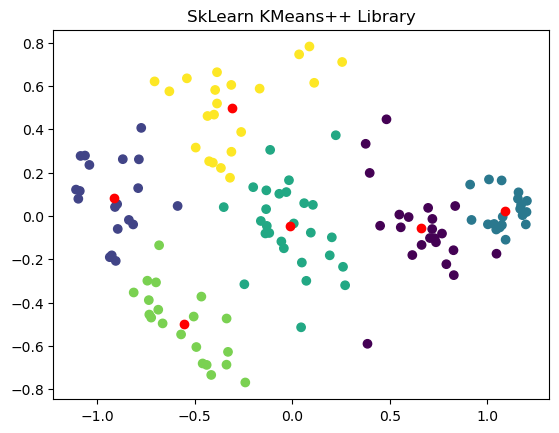

In [29]:
pca = PCA(n_components=2, random_state=265)
data2d = pca.fit_transform(country_info_normalized_km)
centroids2d = pca.transform(orig_centroids)
clear_output(wait=True)
plt.title(f'SkLearn KMeans++ Library')
plt.scatter(x=data2d[:,0],y=data2d[:,1],c=orig_lab)
plt.scatter(x=centroids2d[:,0],y=centroids2d[:,1], c='r')
plt.show()

**Explanation of Clusters on Countries Data**:<br> 
The countries are clustered together based on the several economic/political factors provided on data. For example countries such as "Uruguay","Iceland", "Denmark","Estonia" etc. has been clustered together because they all have similar income inequality (gini index), hdi, populism index, corrpution perection index etc.
On the other hand countries such as "Algeria","Jordan", "Cuba","Qatar" etc. has been clustered together because these countries have lower human development index(hdi), press freedom index and economist_democracy_index.
Similarly other countries like "Singapore","Japan", "Greece","Italy" etc are clustered together as these countires have better human development index(hdi), economist democracy, health coverage etc.<br>


**What if we run kmeans++ algorithm more than once**:<br>
The results will change if we are not restricting the the random initialization using random_state parameter radom seed. If we remove the random_state, then as the very first index is selected randomly from the data set therefore each time the clustering will have diffrerent results as the initial centroids will differ.<br>


**What if we had different social/economic variables?**:<br>
Defnitely the reults will change if we have different social/economic variables. As we are trying to cluster the data therefore the social and economic vairables if changes will contribute differently while measuring the pariwise distance amoung each data point. This will in turn affect the centroids and thus wll generate a different clustering result.<br>

**What is the effect of PCA**:<br>
With PCA we are limiting to only two diemensions here. The number of principal components used in PCA can affect the results and visual interpretation of the data. Choosing a different number of components can result in different amounts of variance being explained and can affect the shape and position of the data in the reduced-dimensional space. It is important to consider the number of components carefully and to evaluate the results using different numbers of components to determine the optimal number for the analysis.